# Projet 9  : Prédire la demande en électricité

### Import des librairies

In [181]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf
from scipy import stats
from pandas.tseries.offsets import MonthEnd
import scipy
import scipy.stats as st
from scipy.stats import t, shapiro, ks_2samp

## 1. Correction des données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

### Import des données de consommation 

In [6]:
ECO_Energie=pd.read_excel("eCO2mix_RTE_energie_M.xlsx")
ECO_Energie = ECO_Energie[ECO_Energie["Territoire"]=="France"][["Mois","Consommation totale"]]
ECO_Energie = ECO_Energie.iloc[1:99]
ECO_Energie= ECO_Energie.rename(columns={"Mois":"Date"})
ECO_Energie["Date"]= pd.to_datetime(ECO_Energie["Date"]) + MonthEnd()

ECO_Energie

,Date,Consommation totale
13,2012-01-31,51086
14,2012-02-29,54476
15,2012-03-31,43156
16,2012-04-30,40176
17,2012-05-31,35257
...,...,...
1084,2019-10-31,36482
1097,2019-11-30,44180
1110,2019-12-31,47096
1123,2020-01-31,43304


Text(0.5, 1.0, 'Consommation totale energie en fonction du temps')

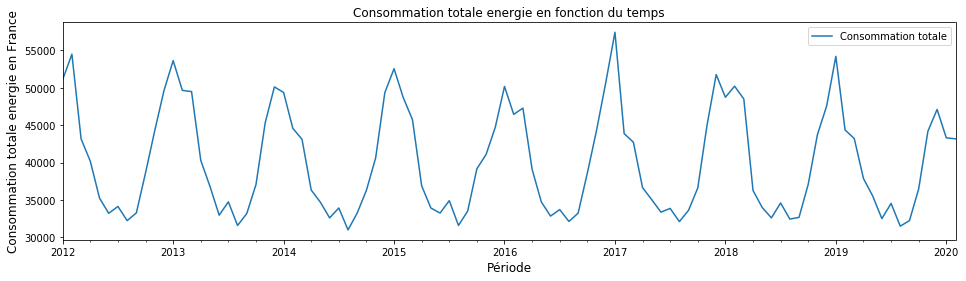

In [8]:
ECO_Energie.set_index("Date").plot(figsize=(16,4))
plt.xlabel('Période', fontsize = 12)
plt.ylabel('Consommation totale energie en France', fontsize = 12)
plt.title('Consommation totale energie en fonction du temps', fontsize = 12)

### Import des données de DJU


On souhaite désaisonnaliser la série temporelle à l'aide de la régression linéaire.  On récupère les données de température sur :
https://cegibat.grdf.fr/simulateur/calcul-dju

In [27]:
DJU_data = pd.read_excel("calcul_DJU_09_06_2020.xlsx", header = 11).drop(columns=["Total"])
DJU_data.rename(columns={'Unnamed: 0':'year'}, inplace=True)
DJU_data = DJU_data.sort_values('year', ascending = True)
DJU_data.set_index('year', inplace = True)
DJU_data

,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC
year,,,,,,,,,,,,
2012,336.0,435.9,210.5,231.2,93.8,50.4,29.8,14.1,72.6,159.2,296.2,345.9
2013,429.2,402.2,376.6,216.3,161.5,57.6,9.3,19.9,55.3,112.0,303.9,349.5
2014,324.4,281.9,226.6,141.8,112.5,37.3,17.7,36.1,34.4,101.3,223.3,368.2
2015,392.0,365.7,275.7,154.6,104.8,36.4,15.8,16.1,81.8,179.6,196.9,248.1
2016,364.4,321.6,321.1,214.1,100.7,40.8,14.7,13.8,27.3,177.3,285.6,390.8
2017,467.9,278.4,208.9,187.1,87.8,21.4,13.5,20.8,74.5,109.3,282.6,369.0
2018,303.4,432.6,314.4,128.9,74.1,20.1,1.6,13.5,53.7,133.4,282.8,325.9
2019,404.9,268.8,234.3,177.2,126.8,0.5,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
DJU_list = pd.Series([i for sublist in DJU_data.values for i in sublist],name="DJU")
DJU_date = pd.Series(pd.date_range(start="2012-01-01", end = "2019-12-31", freq = "M"),name="Date")
data = pd.concat([DJU_date, DJU_list], axis=1)
data = pd.merge(data,ECO_Energie,on='Date')
data

,Date,DJU,Consommation totale
0,2012-01-31,336.0,51086
1,2012-02-29,435.9,54476
2,2012-03-31,210.5,43156
3,2012-04-30,231.2,40176
4,2012-05-31,93.8,35257
...,...,...,...
91,2019-08-31,0.0,31505
92,2019-09-30,0.0,32248
93,2019-10-31,0.0,36482
94,2019-11-30,0.0,44180


In [49]:
data.describe()

,DJU,Consommation totale
count,96.000000,96.000000
mean,171.168750,40030.791667
std,140.243942,7093.466001
min,0.000000,31004.000000
25%,35.675000,33696.750000
50%,148.200000,37082.500000
75%,288.250000,45417.250000
max,467.900000,57406.000000


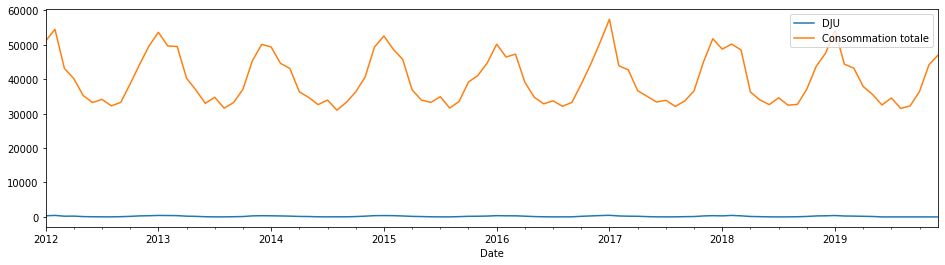

In [42]:
data.set_index("Date").plot(figsize=(16,4))


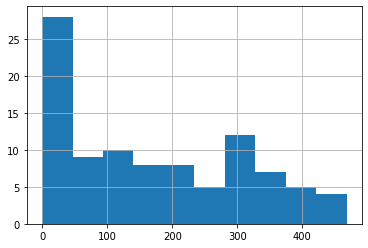

In [48]:
data['DJU'].hist()

In [67]:
# Null values
data.loc[data['DJU'] <= 1]

,Date,DJU,Consommation totale
89,2019-06-30,0.5,32514
90,2019-07-31,0.0,34543
91,2019-08-31,0.0,31505
92,2019-09-30,0.0,32248
93,2019-10-31,0.0,36482
94,2019-11-30,0.0,44180
95,2019-12-31,0.0,47096


In [68]:
DJU_mean = DJU_data.mean(axis=0)
print('Moyenne de juin:',round(DJU_mean[5],1)) 
print('Moyenne de juillet:',round(DJU_mean[6],1)) 
print('Moyenne de aout:',round(DJU_mean[7],1)) 
print('Moyenne de septembre:',round(DJU_mean[8],1)) 
print('Moyenne de octobre:',round(DJU_mean[9],1)) 
print('Moyenne de novembre:',round(DJU_mean[10],1)) 
print('Moyenne de décembre:',round(DJU_mean[11],1)) 


data.loc

Moyenne de juin: 33.1
Moyenne de juillet: 12.8
Moyenne de aout: 16.8
Moyenne de septembre: 49.9
Moyenne de octobre: 121.5
Moyenne de novembre: 233.9
Moyenne de décembre: 299.7


In [107]:
# Attribution des moyennes par mois pour rattraper les valeurs manquantes sur 2019
data.iloc[89,1] = round(DJU_mean[5],1)
data.iloc[90,1] = round(DJU_mean[6],1)
data.iloc[91,1] = round(DJU_mean[7],1)
data.iloc[92,1] = round(DJU_mean[8],1)
data.iloc[93,1] = round(DJU_mean[9],1)
data.iloc[94,1] = round(DJU_mean[10],1)
data.iloc[95,1] = round(DJU_mean[11],1)

# Attribution des moyennes par mois pour rattraper les valeurs manquantes sur 2019
DJU_data.iloc[7,5] = round(DJU_mean[5],1)
DJU_data.iloc[7,6] = round(DJU_mean[6],1)
DJU_data.iloc[7,7] = round(DJU_mean[7],1)
DJU_data.iloc[7,8] = round(DJU_mean[8],1)
DJU_data.iloc[7,9] = round(DJU_mean[9],1)
DJU_data.iloc[7,10] = round(DJU_mean[10],1)
DJU_data.iloc[7,11] = round(DJU_mean[11],1)

Text(0.5, 1.0, 'Consommation totale energie des DJU')

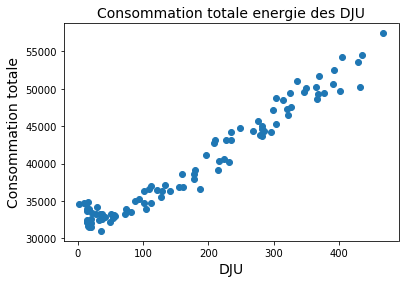

In [137]:
plt.scatter(data["DJU"], data["Consommation totale"])
plt.xlabel('DJU', fontsize = 14)
plt.ylabel('Consommation totale', fontsize = 14)
plt.title('Consommation totale energie des DJU', fontsize = 14)

In [146]:
X=np.asarray(data["DJU"]).reshape(-1,1)
Y=data["Consommation totale"]

reg = linear_model.LinearRegression()
reg.fit(X,Y)

a= reg.coef_
b= reg.intercept_
print(a)
print(b)

[50.81391635]
30926.94924066749


In [145]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels import regression

X=np.asarray(data["DJU"]).reshape(-1,1)
Y=data["Consommation totale"]

model = smf.ols('Y ~ X', data = data).fit(alpha=0.05)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1878.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           6.33e-64
Time:                        15:50:17   Log-Likelihood:                -840.85
No. Observations:                  96   AIC:                             1686.
Df Residuals:                      94   BIC:                             1691.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.093e+04    263.408    117.411      0.000    3.04e+04    3.14e+04
X             50.8139      1.173     43.335      0.000      48.486      53.142
==============================================================================
Omnibus:                        1.589   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.452   Jarque-Bera (JB):                1.602
Skew:                           0.243   Prob(JB):                        0.449
Kurtosis:                       2.595   Cond. No.                         372.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [149]:
data['Conso_corrigée_DJU'] = data["Consommation totale"] - a*data["DJU"]
data

,Date,DJU,Consommation totale,Conso_corrigée_DJU
0,2012-01-31,336.0,51086,34012.524106
1,2012-02-29,435.9,54476,32326.213862
2,2012-03-31,210.5,43156,32459.670608
3,2012-04-30,231.2,40176,28427.822540
4,2012-05-31,93.8,35257,30490.654646
...,...,...,...,...
91,2019-08-31,16.8,31505,30651.326205
92,2019-09-30,49.9,32248,29712.385574
93,2019-10-31,121.5,36482,30308.109163
94,2019-11-30,233.9,44180,32294.624965


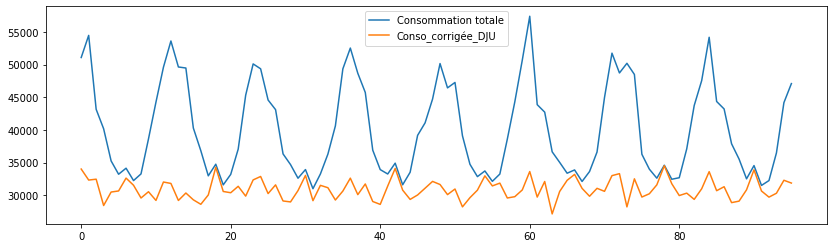

In [151]:
data["Consommation totale"].plot(figsize=(14,4), legend = True)
data["Conso_corrigée_DJU"].plot(legend = True)

## Vérification des hypothèses du modèles linéaire

HO: les résidus suivent une loi normale

H1: les résidus ne suivent pas une loi normale

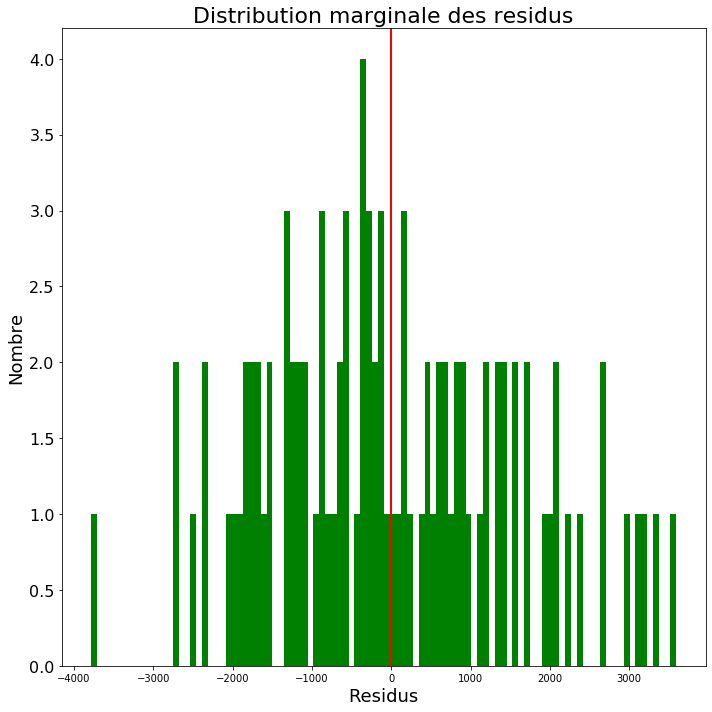

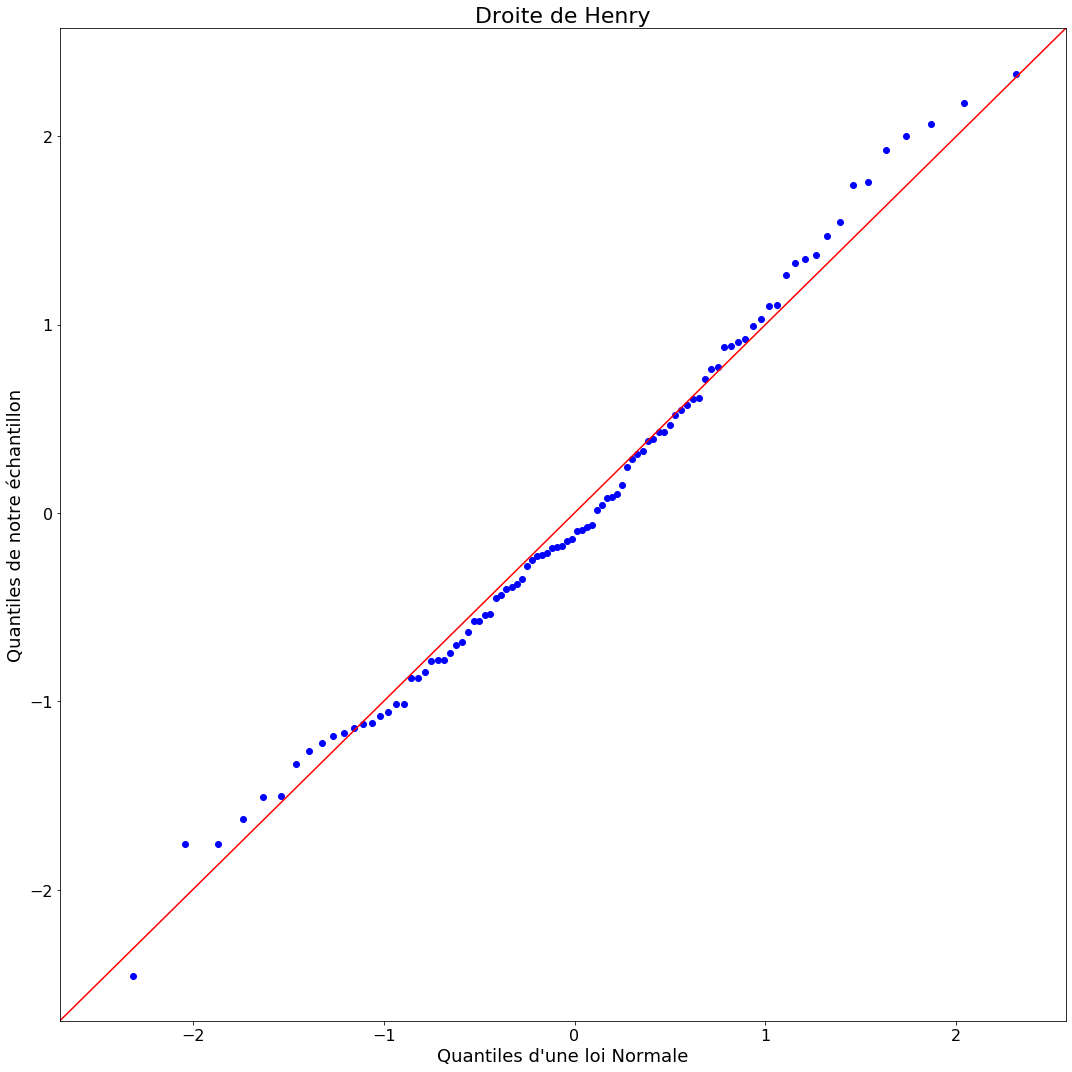

In [167]:
# Préparation des données
X = model.resid
Xbar = np.mean(X)
Xsprime = np.std(X)

#Représentation de la distribution marginale
plt.figure(figsize=(10,10))

plt.hist(X, 100, facecolor='g')
plt.axvline(Xbar, color='r', linewidth=2)

plt.title(f'Distribution marginale des residus', fontsize=22)
plt.ylabel('Nombre',fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Residus',fontsize=18)
plt.yticks(fontsize=16)

plt.tight_layout()

#plt.savefig('Graphiques/dist_marg_resid_anova.png')
plt.show()


# Droite de Henry
fig, ax = plt.subplots(figsize=(15, 15))

sm.qqplot(X, line='45', fit=True, ax=ax)

plt.ylabel('Quantiles de notre échantillon', fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel('Quantiles d\'une loi Normale',fontsize=18)
plt.xticks(fontsize=16)
plt.title('Droite de Henry', fontsize=22)

plt.tight_layout()

#plt.savefig('Graphiques/Droite_de_Henry_ANOVA.png')

plt.show()



In [169]:
# Test d'adequation à une loi (ici Normale) avec le test Kolmogorv-Smirnov
print('Test de Kolmodorov Smirnov',ks_2samp(X,list(np.random.normal(Xbar, Xsprime, 11600))))

Test de Kolmodorov Smirnov Ks_2sampResult(statistic=0.06727011494252871, pvalue=0.7820347548249854)


La p-value est supérieure au seuil de 5 %, on accepte H0, les résidus suivent une loi normale

## Vérification de l' homoscédasticité des résidus

H0: Homoscédasticité

H1: Hétéroscédasticité

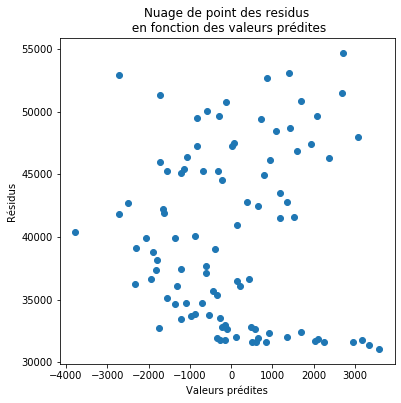

Test de Breushch Pagan : (0.08438946039159134, 0.7714347903435711, 0.08270404819592833, 0.7742989293882334)


In [170]:
plt.figure(figsize=(6,6))
plt.scatter(model.resid, model.predict())

plt.ylabel('Résidus')
plt.xlabel('Valeurs prédites')
plt.title('Nuage de point des residus\n en fonction des valeurs prédites')

#plt.savefig('graph/homoscedasticity2.png')
plt.show()

print('Test de Breushch Pagan :',sm.stats.diagnostic.het_breuschpagan(model.resid, model.model.exog))

Les p-values sont supérieures au seuil de 5 %, on accepte H0, les résidus sont homoscédastiques.

## Vérification de l'hypothèse d' indépendance des résidus
H0: Les résidus sont indépendants

H1: Les résidus ne sont pas indépendants

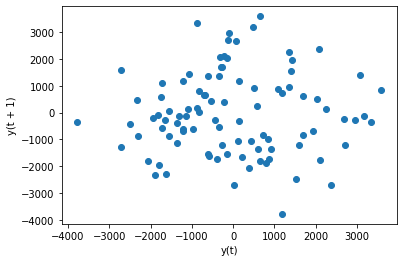

Test de Durbin Watson : 1.904990694966102


In [173]:
pd.plotting.lag_plot(model.resid)
plt.show()

print('Test de Durbin Watson :',sm.stats.stattools.durbin_watson(model.resid, axis=0))

La valeur est proche de 2, on accepte H0, les résidus sont indépendants.

## 2. Désaisonnalisation de la consommation obtenue après correction, grâce aux moyennes mobiles.

Appercu des écarts entre les pics et les creux sur une période pour définir si le modème est additif ou multiplicatif

In [159]:
x = data[['Date','Conso_corrigée_DJU']].set_index("Date")

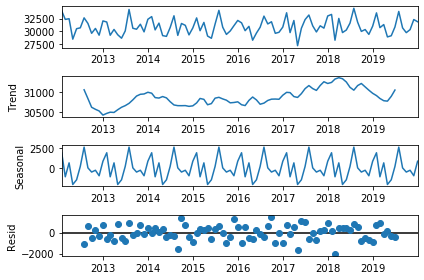

In [185]:
# Modèle additif / La série temporelle est la somme de la tendance des saisonalités et des résidus
decomp_x = seasonal_decompose(x,  model='additive')
decomp_x.plot()
plt.show()